前面教程中，我们通过优化检索器、召回器，以及各种召回策略来提升了RAG系统的检索精度，但最终回复的结果还需要经过大模型的融合和处理，模型能力的强弱直接影响到最终的结果。这就好比一道好的菜不仅需要有高质量的好食材（优化的检索模块提供高匹配度文本），还需要有一个好的厨师（能力强的LLM融合信息来生成答案）。本节教程我们将进一步提升RAG系统的精度，深入到RAG系统中的生成模块，讨论大模型在其中的作用，介绍如何通过LazyLLM的微调来显著提升大模型的生成能力，甚至以小模型超越通用大模型（即：训练出一个好的厨师），进而提升RAG系统的回复质量。

# **大模型在RAG系统中的作用**

## RAG流程的回顾

前面教程中，我们已可以快速搭建出RAG系统，让我们快速回顾一下RAG的运行流程：

* 检索模块会根据用户的Query去查询知识库中通过向量相似度来召回Top-K相关的文档；
* 生成模块将检索结果与用户Query拼接，输入LLM生成最终响应Response；

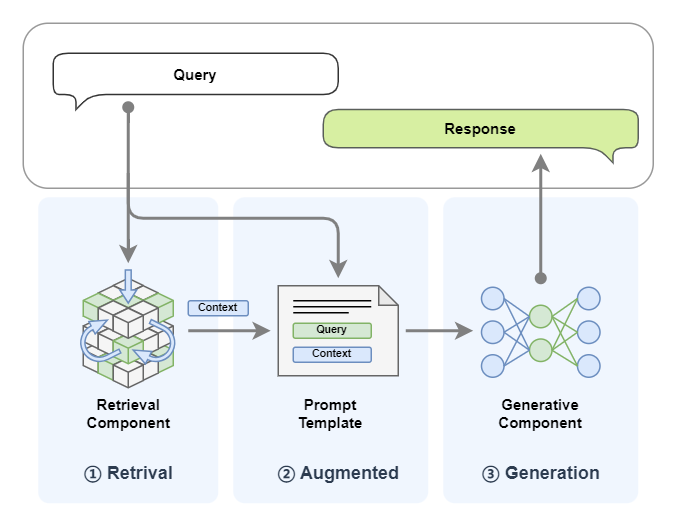

从中我们可以看到LLM大模型在RAG系统中主要承担内容生成的作用。具体我们可以总结如下：

* ​**语义理解**​：解析query的真实意图；
* ​**知识融合**​：协调原始知识（LLM大模型固有的知识）与新增知识（检索内容）的融合；
* ​**逻辑推理**​：基于query的意图和上下文推理出一个合理的结果；

所以影响RAG系统精度主要有两个因素：

**召回的效果** + **模型内容生成的能力**

前几期教程，我们已详细介绍过如何提升召回效果（快速回看：[第7讲：检索升级实践：亲手打造“更聪明”的文档理解系统！](../chapter7/7.ipynb)、[第6讲：检索更准：RAG召回效果优化的底层逻辑与技巧](../chapter7/7.ipynb)），本期我们将聚焦在生成模块的模型能力增强上，来提高模型生成内容的质量。

## 模型能力的影响

在典型RAG架构中，大语言模型（LLM）的基准能力直接影响系统最终输出的可靠性，其性能瓶颈主要体现在以下三个维度：

### **1. 领域知识适配性缺陷**

通用大模型（如DeepSeek-R1、GPT-4、Claude-3）在开放域知识理解上展现较强能力，但面对垂直领域时表现显著下降：

* ​**专业术语解析障碍**​：比如IC 在医学领域可以指 “Intensive Care” (重症监护)，在电子学领域指：“Integrated Circuit” (集成电路)。
* ​**长尾知识缺失**​：
  * 在医疗领域，通用大模型在训练时可能主要接触常见疾病的数据，对于罕见疾病的数据接触较少，导致当模型遇到罕见疾病的病例时，可能无法准确识别或诊断，导致误诊或漏诊；
  * 在在自然语言处理中，通用模型通常以普通话或主流语言为主进行训练，对于地方方言的训练数据较少；导致模型在处理地方方言时可能出现理解错误或无法理解的情况，影响交流效果；
  * 在文化知识问答或推荐系统中，通用模型对于主流文化知识掌握较好，但对于小众文化知识了解不足，导致用户询问关于小众文化的问题时，模型可能无法给出准确或相关的回答。
* ​**领域推理能力局限**​：
  * 在法律领域，通用大模型被用于辅助分析案件，在处理复杂法律案件时，可能无法理解深层的法律逻辑和条文之间的关联，导致模型提供的分析建议可能不够准确或全面，影响法律决策；
  * 在教育领域，通用大模型被用于辅助数学问题求解，模型在处理高级数学问题时，可能无法进行深入的推理和计算，模型无法解决复杂数学问题，或给出的解答错误；
  * 在科学研究领域，通用大模型被用于辅助设计实验，模型可能缺乏对特定科学领域的深入理解，无法考虑到所有实验变量和潜在影响，导致设计的实验可能存在缺陷，无法达到预期的研究目标。

### **2. 结构化输出控制薄弱**

当系统要求固定格式输出（如JSON数据表、标准化报告）时，模型易受两个关键问题影响：

* ​**格式漂移现象**​：
  * 在金融数据分析中，模型需要输出标准化的JSON格式数据表。然而，由于模型对格式细节的掌握不够精确，导致输出的JSON数据中某些字段的嵌套层级错误，如将本应属于子字段的数据直接放在了父字段下，造成数据解析失败；
  * 在电商领域，模型负责生成商品信息的JSON数据。但由于格式漂移，模型输出的数据中出现了不必要的空格、换行或缺失引号等，导致前端系统在解析时出现错误，影响商品展示；
* ​**幻觉干扰**​：
  * 在医疗报告生成场景下，模型需要按照固定格式输出包含患者基本信息、诊断结果、治疗方案等字段的报告。然而，模型在生成报告时自我发挥，虚构了格式之外的非关键字段内容，如添加了不存在的检查项目或治疗建议，导致报告内容失真，可能对医生诊断造成干扰；
  * 在法律文书生成中，模型需要按照标准模板输出文书。但由于幻觉干扰，模型在文书中添加了与案件无关的虚构事实或法律条文，导致文书内容不准确，影响法律效力；

### **3. 性能被部署环境限制**

RAG需要的知识库往往对用户来说具有隐私性，用户更希望能在本地部署，这意味着要同时部署本地的大模型，而本地部署大模型又需要算力支持，一般用户很难有较强的算力，此时在算力资源下往往只能选择一些较小的LLM模型，比如7B大小的模型，而这些较小的LLM基本能力上无法和600多B的LLM相比，此时模型的能力也就较弱。所以隐私保护需求迫使企业采用本地化部署方案，但由此产生算力约束：

* ​**模型规模限制**​：单台A100服务器（80G显存）最大支持70B参数模型的部署，而同等成本下云端可调用600B级的DeepSeek-R1；
* ​**能力代际差异**​：比如在LLaMA-7B模型的准确率显著低于LLaMA-65B的准确率。

# 微调提升大模型能力

上面提及的问题，一定程度上都可以通过具有针对性的微调策略来解决，进而可显著提升RAG系统中生成模块的领域适应能力和输出规范性。

**🧐 那什么是微调？**

—— 微调就是基于预训练大模型，通过特定领域数据二次训练，使模型适配专业场景的轻量化技术。

## 微调核心方法

* 监督微调(SFT)：注入领域QA数据（如法律案例/医疗报告）
* 领域自适应：LoRA低秩适配技术，冻结原参数+训练适配层

## 核心优势

* 高效性：7B模型经微调后，特定任务表现可比肩未调优的70B模型
* 低成本：参数高效微调(PEFT)仅需更新0.1%\~20%参数量
* 可控性：强化结构化输出和内容输出约束（如JSON格式校准）

## 典型应用场景

**​（1）​**​**领域知识适配性增强**

**a. ​**​​**垂直领域知识注入**​： 基于领域专用数据（如医学病例、法律文书、科研论文）构建微调数据集，通过指令微调（Instruction Tuning）使模型学习领域内知识表达模式。例如，在医疗场景中，使用<症状描述，诊断建议>数据对训练模型理解医学术语间的关联性。

**b. ​**​​**长尾知识补偿**​： 针对罕见术语或低频场景（如方言词汇、小众文化概念），构造包含此类知识的问答对，通过微调增强模型对长尾特征的捕捉能力。例如，在方言处理任务中，向训练数据注入方言-标准语对照样本，强化模型跨语言变体的泛化能力。

**​（2）​**​**结构化输出控制强化**

**a. ​**​​**格式标记显式学习​**​： 在微调数据中嵌入结构化标记（如`{{KEY_START}}诊断结果{{KEY_END}}`），强制模型学习格式与内容的分离表达。

**b. ​**​​**抗干扰训练**​： 向训练集注入20%-30%的噪声样本（如随机删除引号、打乱JSON层级），要求模型在修复格式的同时保持内容准确性。通过这种方式提升模型对格式漂移的鲁棒性。

**c. ​**​**轻量化部署适配环境**

​**小模型能力增强**​：通过​**渐进式知识迁移**​，将大模型在领域任务中习得的能力蒸馏至小模型。例如，使用大模型生成领域相关数据的伪标签（也可直接使用相关专业领域内的标注数据），再基于此数据微调小模型，使7B模型在特定任务上逼近65B模型的表现。

这里我们例举一个具体的场景：

在医疗领域，需要将医疗报告中的文本信息（例如，“患者表现出高血压症状，收缩压为150mmHg”）转换为JSON格式，包含症状、血压读数等关键信息。

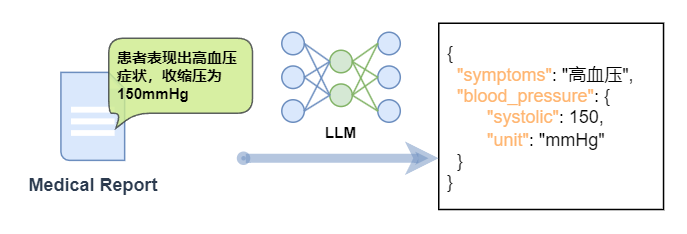

在微调下，针对这类任务可以有以下益处：

 **1.精确的信息提取**​：
   - 微调可以帮助模型更准确地从自然语言文本中提取出需要结构化的信息，例如症状类型、数值、单位等。

​**2. 上下文理解**​：
   - 自然语言中的信息往往依赖于上下文，微调可以让模型更好地理解这些上下文，从而更准确地转换信息。

​**3. 特定格式的要求**​：
   - JSON结构化文本通常有严格的格式要求，微调可以帮助模型生成符合这些要求的输出。
   
​**4. 领域特定术语的处理**​：
   - 微调可以帮助模型更好地理解和处理专业术语。

自然语言转换为JSON结构化的文本是一个典型的场景，其中微调可以显著提高LLM的性能和输出质量。通过微调，模型可以学习到如何从自然语言中识别和提取关键信息，并以一种预定义的结构化格式呈现这些信息。

让我们将微调后的模型放到 RAG 中去，就是这样子的：

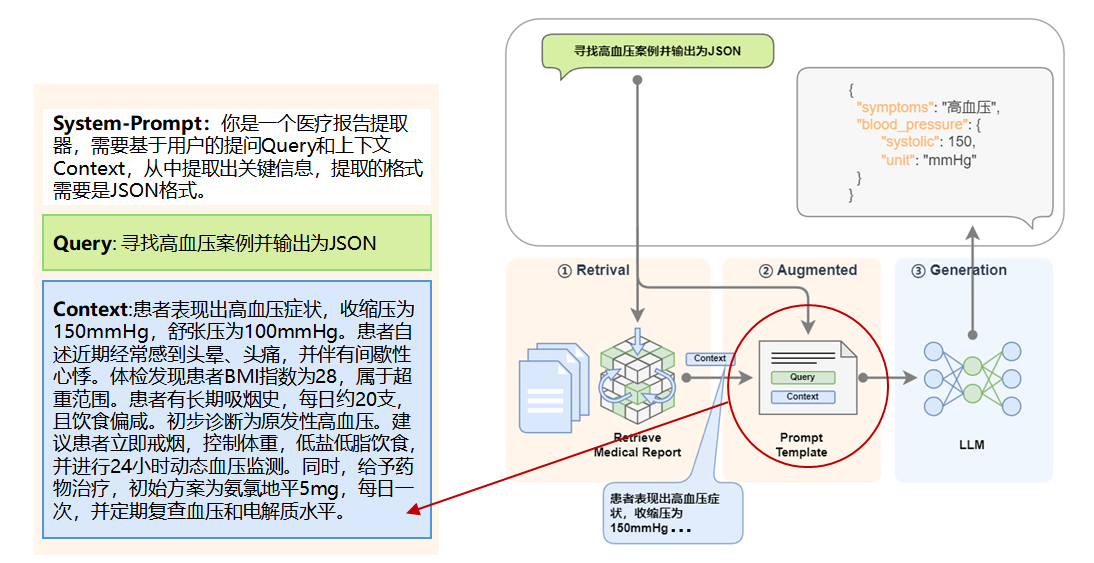

# LoRA 微调的原理和方法

上面我们提到微调可以解决各种问题，那么用什么具体的微调方法呢？

针对传统全参数微调在资源消耗和灾难性遗忘方面（过度调整预训练权重会破坏模型在通用领域的知识表达）的固有挑战，LorRA（Low-Rank Adaptation）微调提供了有效的优化途径，成为模型微调领域的常用方法。

## LoRA微调概述

下面我们以LoRA微调为例，讲解一下微调在LazyLLM中的应用。

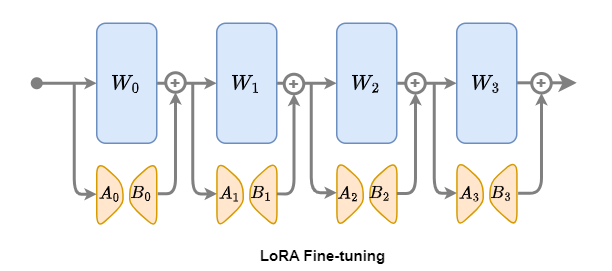

LoRA 微调是一种针对 Transformer 模型设计的先进微调技术，其核心思想是在保持预训练模型参数 $W \in \mathbb{R}^{d \times k}$ 固定不变的基础上，通过引入低秩矩阵 $A$ 和 $B$ 来模拟并实现微调过程。

这种方法的独特之处在于，它并非直接调整原模型中的参数 $W \in \mathbb{R}^{d \times k}$（如 $W_0$、$W_1$、$W_2$、$W_3$），而是为每一层额外引入可训练的参数——橙色矩阵 $B \in \mathbb{R}^{d \times r}$ 和 $A \in \mathbb{R}^{r \times k}$，仅对这些低秩矩阵进行微调。

## LoRA微调步骤

1. 加载预训练模型：首先，选择一个已经预训练好的 Transformer 模型作为基础。  
2. 引入低秩矩阵：在模型的每一层中，添加可训练的低秩矩阵 $B \in \mathbb{R}^{d \times r}$ 和 $A \in \mathbb{R}^{r \times k}$。  
3. 微调低秩矩阵：将特定任务的数据输入模型，利用反向传播算法针对低秩矩阵 $A$ 和 $B$ 进行参数更新。  
4. 评估与优化：在验证集上对微调后的模型进行性能评估，并根据实际需求进一步优化模型。

## LoRA数学解析

更深入一步，我们来看LoRA的数学解析。LoRA（Low-Rank Adaptation）方法基于低秩矩阵近似理论，通过冻结预训练模型的参数并注入可训练的低秩矩阵，实现了参数的高效微调。在数学层面，对于预训练权重矩阵$W ∈ R^{d×k}$，LoRA 将其更新量分解为两个低秩矩阵的乘积：

$$ΔW = B ⋅ A$$

其中，$B \in \mathbb{R}^{d \times r}$，$A \in \mathbb{R}^{r \times k}$，且 $r \ll \min(d, k)$。这样的分解使得更新量具有更低的秩，从而减少了需要训练的参数数量。

在前向传播过程中，模型的输出变为：

$$
h = Wx + \dfrac{\alpha}{r}BAx
$$

其中：

- $W$ 是预训练模型的原始权重矩阵  
- $x$ 是输入  
- $B$ 和 $A$ 是低秩矩阵（秩为 $r$）  
- $\alpha$ 是缩放因子，用于灵活控制低秩矩阵对原始权重的调整强度。  
- $r$ 是秩  

**低秩矩阵近似 — SVD**

LoRA（Low-Rank Adaptation）方法基于低秩矩阵近似理论，我们先基于基于奇异值分解（Singular Value Decomposition, SVD）来看低秩矩阵近似理论。SVD广泛应用于降维、特征提取、噪声过滤、推荐系统和自然语言处理（如 Latent Semantic Analysis）等领域。

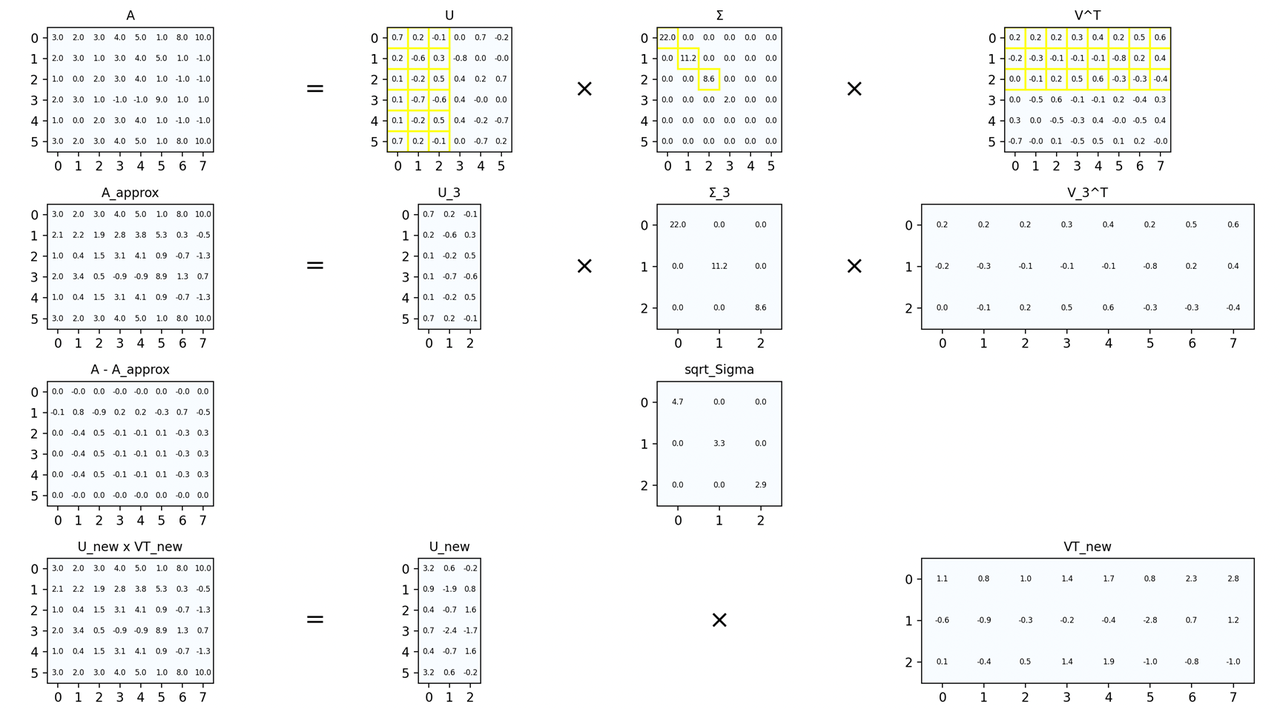

在 SVD 中，对任意一个实矩阵 $A \in \mathbb{R}^{m \times n}$，$A$ 可以被表达为 $A = U \Sigma V^T$，其中 $U \in \mathbb{R}^{m \times m}$，$\Sigma \in \mathbb{R}^{m \times n}$，$V \in \mathbb{R}^{n \times n}$ 或 $U \in \mathbb{R}^{m \times k}$，$\Sigma \in \mathbb{R}^{k \times k}$，$V \in \mathbb{R}^{n \times k}$，$k = \min(m, n)$。

​**1. 秩 $r$ 的影响**

* 参数效率与模型容量

  * $r$ 决定了低秩矩阵 $BA$ 的近似能力。

    * 较大的 $r$ 允许矩阵捕捉更复杂的更新，提升模型对任务的适应能力，但会增加训练参数（参数量为 $r \times (\text{dim}_A + \text{dim}_B)$），可能导致过拟合。
    * 较小的 $r$ 则减少参数量，提升训练速度，但可能限制模型表达能力。
* 过拟合与泛化

  * 小 $r$：更适合小数据集，减少过拟合风险，但可能欠拟合复杂任务。
  * 大 $r$：适合大数据集或复杂任务，但需更多数据避免过拟合。
* 经验值：通常 $r = 8$ 或 $16$ 在多数任务中表现平衡。

​**2. 缩放因子 $\alpha$ 的影响**

* 更新幅度控制

  * $\alpha$ 调节低秩更新项 $BAx$ 的权重。

    * 较大的 $\alpha$ 增强增量更新的影响，可能加快收敛，但也可能破坏预训练知识；
    * 较小的 $\alpha$ 使更新更温和，保留更多原始模型能力，但需要更长训练时间。
* 与秩的协同作用

  * 公式中的 $\frac{\alpha}{r}$ 设计平衡了不同 $r$ 值的影响。例如，当 $r$ 增大时，除以 $r$ 可以防止更新幅度过大，保持训练稳定性。
* 经验值：通常 $\alpha$ 设为 $r$ 的 2 倍（如 $\alpha = 16$）

​**3. $\frac{\alpha}{r}$ 的影响**

* 更新强度与收敛速度

  * $\frac{\alpha}{r}$ 直接控制低秩项的整体贡献：

    * 比例高（如大 $\alpha$ 或小 $r$）：更新强度大，适合快速适应新任务，但可能引起梯度不稳定。
    * 比例低（如小 $\alpha$ 或大 $r$）：更新温和，适合保留预训练知识，需更长时间微调。
* 与学习率的关系

  * $\frac{\alpha}{r}$ 的作用类似于针对低秩项的自适应学习率。

**4. 预训练权重冻结的影响**

* 灾难性遗忘的缓解

  * 原始权重 $W$ 被冻结，仅训练 $B$ 和 $A$，避免破坏预训练知识，显著减少过拟合风险。
* 计算效率

  * 训练参数减少至低秩矩阵的规模（如从亿级参数降至百万级），节省显存和计算资源。

### 参数调优建议

* 任务复杂度与数据量

  * 简单任务/小数据：选择较小 $r$（如 $r=4$）和中等 $\alpha$。
  * 复杂任务/大数据：尝试较大 $r$（如 $r=32$）并调高 $\alpha$。
* 资源限制

  * 显存不足时优先降低 $r$，而非减小模型尺寸。

### 参数总结

* $r$：平衡表达能力和参数效率，决定模型微调的灵活性。
* $\alpha$：调节新知识的注入强度，与 $r$ 共同控制训练稳定性。
* $\frac{\alpha}{r}$：直接影响收敛速度和最终效果，需根据任务需求调整。

# 基于LazyLLM对大模型进行微调

那么我们应该如何实现微调呢？这里我们基于LazyLLM来具体实现一个LoRA微调。

我们选择一个小模型，使用CMRC2018数据集中的训练数据来微调这个小模型，让它能具有更好的中文阅读理解信息抽取能力。之前在RAG中使用的模型都会基于我们检索到的知识库信息来回答问题，回答地比较发散，自由发挥程度比较高，这里我们希望RAG中的模型有如下特点：

1. 根据用户提问和召回的文段，抽取必要的信息来回答，不要扩展发挥（对应上文提到的：结构化输出控制薄弱和领域知识适配性差）；
2. 模型要小，大约7B左右，方便部署，不能用太大的模型（对应上文提到的：轻量化部署需求和模型精度下降的矛盾）。

我们整体的微调步骤如下：

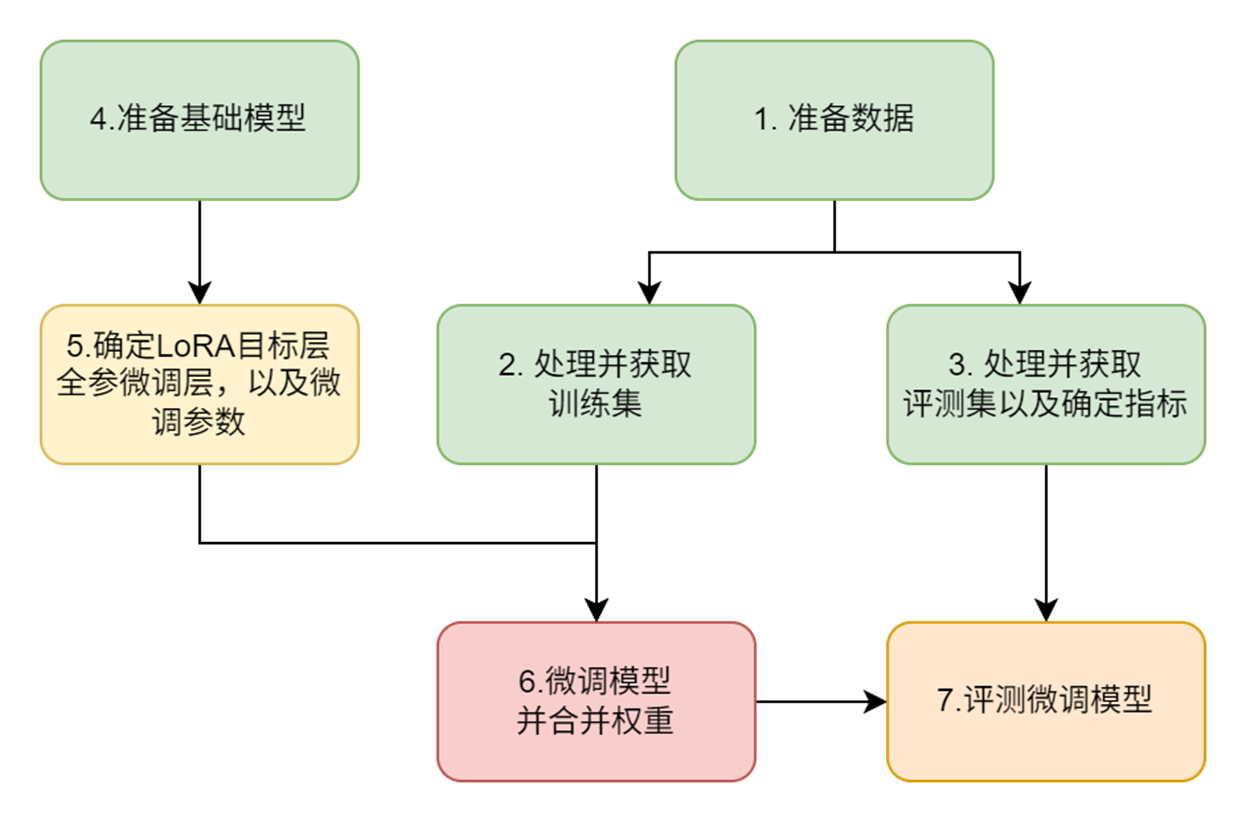

* 问题：原RAG中大模型回答发散，需精简+准确遵循原文输出；
* 目标：在7B的小模型上，强化中文阅读理解信息抽取能力
* 模型选择：InternLM2-Chat-7B。
* 数据准备：使用CMRC2018训练数据，聚焦中文问答与信息抽取。
* 微调方法：
  * LoRA策略：冻结原始权重，仅训练低秩矩阵（BA），降低显存占用。
  * 控制输出：强化遵循原文内容且精简输出的能力。

## 数据准备

### 数据集简介

我们选用CMRC2018数据集，该数据集由近15,000个真实问题组成，这些问题是由人类专家在**维基百科**段落上标注而成。另外该数据集对应的任务是：“篇章片段抽取型阅读理解”(Span-Extraction Reading Comprehension)，根据给定的一个文档和一个问题，模型需要从该文档中抽取出问题的答案，其中答案是该文章某个连续的片段。

### 数据集规模

CMRC2018数据集主要由三部分构成：test、validation 和train。这里我们将train部分作为我们的训练集，test部分作为我们的评测集，validation部分我们不使用。

| **数据集** | **短文数** | **问题数** | **用途** |
| ------------------ | ------------------ | ------------------ | ---------------- |
| test             | 256              | 1002             | 评测集         |
| train            | 2403             | 10142            | 训练集         |
| validation       | 848              | 3219             | 未使用         |

注意：

* 之前教程中的知识库是基于 **CMRC2018 ​**中的test数据集中的文段来构建的；
* 这里训练我们使用的 **CMRC2018 ​**中的train数据集来进行；
* 评测过程，为避免RAG系统中检索模块干扰，我们采用控制变量法，假设召回100%没问题，即：我们直接使用 **CMRC2018 ​**中的test数据集中的文段片段和问题拼接起来作为大模型LLM的输入，变量是微调前后的两个7B的模型，以对比查看微调后模型在中文阅读理解信息抽取能力方面是否有提升；

### 数据的结构

数据集中的test和train的结构是一致的，我们抽取其中的一条数据来看如下：

In [ ]:
[
    {
        "id": "TRIAL_154_QUERY_0",
        "context": "尤金袋鼠（\"Macropus eugenii\"）是袋鼠科中细小的成员，通常都是就袋鼠及有袋类的研究对象。尤金袋鼠分布在澳洲南部岛屿及西岸地区。由于牠们每季在袋鼠岛都大量繁殖，破坏了针鼹岛上的生活环境而被认为是害虫。尤金袋鼠最初是于1628年船难的生还者在西澳发现的，是欧洲人最早有纪录的袋鼠发现，且可能是最早发现的澳洲哺乳动物。尤金袋鼠共有三个亚种：尤金袋鼠很细小，约只有8公斤重，适合饲养。尤金袋鼠的奶中有一种物质，称为AGG01，有可能是一种神奇药及青霉素的改良。AGG01是一种蛋白质，在实验中证实比青霉素有效100倍，可以杀死99%的细菌及真菌，如沙门氏菌、普通变型杆菌及金黄色葡萄球菌。",
        "question": "尤金袋鼠分布在哪些地区？",
        "answers": {
            "text": [
                "尤金袋鼠分布在澳洲南部岛屿及西岸地区"
            ],
            "answer_start": [
                52
            ]
        }
    },
...

上面数据中：

* `context`: 是文本段；
* `question`：是针对文本段的提问；
* `answers`：给出了对应问题的答案，包括：
  * `text`：答案的具体内容，源自文本段；
  * `answer_start`：答案在文本段中的起始位置；

### 训练集处理

* 我们从原train数据集中抽取出文章字段`context`和问题字段`question`，将它拼接成为用于微调的`instruction`字段，拼接模板是："请用下面的文段的原文来回答问题\\n\\n### 已知文段：{context}\\n\\n### 问题：{question}\\n"。
* 将原数据中的`answers`及其`text`字段作为，微调的 `output` 字段
* 由于微调还需要一个`input`字段，而我们这个任务不需要，所以设置为空。

[代码Github链接🔗](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter9/run_cmrc.py#L51)

In [ ]:
# Template for constructing QA prompts
template = "请用下面的文段的原文来回答问题\n\n### 已知文段：{context}\n\n### 问题：{question}\n"

def build_train_data(data):
    """Format training data using predefined template"""
    extracted_data = []
    for item in data:
        extracted_item = {
            "instruction": template.format(context=item["context"], question=item["question"]),
            "input": "",
            "output": item["answers"]["text"][0]
        }
        extracted_data.append(extracted_item)
    return extracted_data

我们取处理后的一条数据如下：

In [ ]:
[
    {
        "instruction": "请用下面的文段的原文来回答问题\n\n### 已知文段：黄独（学名：）为薯蓣科薯蓣属的植物。多年生缠绕藤本。地下有球形或圆锥形块茎。叶腋内常生球形或卵圆形珠芽，大小不一，外皮黄褐色。心状卵形的叶子互生，先端尖锐，具有方格状小横脉，全缘，叶脉明显，7-9条，基出；叶柄基部扭曲而稍宽，与叶片等长或稍短。夏秋开花，单性，雌雄异株，穗状花序丛生。果期9-10月。分布于大洋洲、朝鲜、非洲、印度、日本、台湾、缅甸以及中国的江苏、广东、广西、安徽、江西、四川、甘肃、云南、湖南、西藏、河南、福建、浙江、贵州、湖北、陕西等地，生长于海拔300米至2,000米的地区，多生于河谷边、山谷阴沟或杂木林边缘，目前尚未由人工引种栽培。在美洲也可发现其踪迹，对美洲而言是外来种，有机会在农田大量繁殖，攀上高树争取日照。英文别名为air potato。黄药（本草原始），山慈姑（植物名实图考），零余子薯蓣（俄、拉、汉种子植物名称），零余薯（广州植物志、海南植物志），黄药子（江苏、安徽、浙江、云南等省药材名），山慈姑（云南楚雄）\n\n### 问题：黄独的外皮是什么颜色的？\n",
        "input": "",
        "output": "外皮黄褐色"
    },
...

### 评测集处理

我们评测集的字段基本都保留了下来，仅对answers字段进行了处理，将其中的内容提取了出来：

[代码Github链接🔗](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter9/run_cmrc.py#L39)

In [ ]:
def build_eval_data(data):
    """Extract necessary fields for evaluation dataset"""
    extracted_data = []
    for item in data:
        extracted_item = {
            "context": item["context"],
            "question": item["question"],
            "answers": item["answers"]["text"][0]
        }
        extracted_data.append(extracted_item)
    return extracted_data

我们取处理后的一条数据如下：

In [ ]:
[
    {
        "context": "芙蓉洞位于重庆武隆县江口镇的芙蓉江畔，距武隆县城20公里。芙蓉洞于1993被发现，1994年对游人开放。2002年被列为中国国家4A级旅游景区，2007年6月作为中国南方喀斯特－武隆喀斯特的组成部分被列入联合国世界自然遗产，是中国首个被列入世界自然遗产的溶洞。芙蓉洞全长2846米，以竖井众多、洞穴沉积物类型齐全著称。芙蓉洞附近的天星乡境内，有世界上罕见的喀斯特竖井群。在约20平方公里的范围内，至少散布着50个超过100米的竖井，其中汽坑洞的深度为920米，为亚洲第一。芙蓉洞内有70多种沉积物，几乎包括了所有经过科学家命名的喀斯特洞穴沉积类型，其中池水沉积堪称精华。在芙蓉洞的东端有一个“石膏花支洞”，洞内的鹿角状卷曲石枝长57厘米，为世界第一。目前石膏花支洞被永久封存。在紧邻芙蓉洞洞口的芙蓉江上已经建起了江口电站大坝，水库蓄水后对地下水循环及喀斯特景观的演化造成的影响目前还难以估量。",
        "question": "芙蓉洞位于什么地方？",
        "answers": "重庆武隆县江口镇的芙蓉江畔"
    },
 ...

## 微调模型

在数据处理完成后，我们可以开始进行微调了。

值得注意的是：LazyLLM支持微调、部署、推理一条龙！

微调相关配置代码主要如下所示：

[代码GitHub链接🔗](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter9/run_cmrc.py#L155)

In [ ]:
import lazyllm
from lazyllm import finetune, deploy, launchers

model = lazyllm.TrainableModule(model_path)\
    .mode('finetune')\
    .trainset(train_data_path)\
    .finetune_method((finetune.llamafactory, {
        'learning_rate': 1e-4,
        'cutoff_len': 5120,
        'max_samples': 20000,
        'val_size': 0.01,
        'per_device_train_batch_size': 2,
        'num_train_epochs': 2.0,
        'launcher': launchers.sco(ngpus=8)
    }))\
    .prompt(dict(system='You are a helpful assistant.', drop_builtin_system=True))\
    .deploy_method(deploy.Vllm)
model.evalset(eval_data)
model.update()

上面代码中，使用LazyLLM的`TrainableModule`来实现：微调->部署->推理:

* 模型配置：
  * `model_path`指定了我们要微调的模型，这里我们用Internlm2-Chat-7B，直接指定其所在路径即可；
* 微调配置：
  * `.mode`设置了启动微调模式`finetune`；
  * `.trainset `设置了训练用的数据集路径，这里用到的就是我们前面处理好的训练集；
  * `.finetune_method` 设置了用哪个微调框架及其参数，这里传入了一个元组（只能设置两个元素）：
    * 第一个元素指定了使用的微调框架是Llama-Factory：`finetune.llamafactory`
    * 第二个元素是一个字典，包含了对该微调框架的参数配置；
* 推理配置：
  * `.prompt `设置了推理时候用的Prompt，注意，这里为了和微调的Prompt中的system字段保持一致，所以开启`drop_builtin_system`以将原system-prompt给替换为\`You are a helpful assistant.\`
  * `.deploy_method `设置了部署用的推理框架，这里指定了vLLM这个推理框架；
* 评测配置：
  * 这里通过`.evalset`来配置了我们之前处理好的评测集；
* 启动任务：
  * `.update` 触发任务的开始：模型先进行微调，微调完成后模型会部署起来，部署好后会自动使用评测集全部都过一遍推理以获得结果；

微调中的一些关键参数如下：

| **参数**                  | **作用**   | **推荐设置** | **调优建议**             |
| --------------------------------- | ------------------ | -------------------- | -------------------------------- |
| learning\_rate                  | 控制参数更新幅度 | 1e-4\~5e-5         | 大模型取较小值                 |
| cutoff\_len                     | 最大上下文长度   | 5120               | 根据GPU显存调整                |
| max\_samples                    | 最大训练样本量   | 20000              | 注意太小导致训练用的数据太少， |
| per\_device\_train\_batch\_size | 单卡批次大小     | 2                  | 显存不足时减小                 |
| num\_train\_epochs              | 训练轮次         | 2.0                | 根据任务loss下降情况来设置     |

额外，我们还可以配置一些LoRA相关的参数（LazyLLM已经默认设置好了一套经验的参数，所以上述代码中没有体现，这里我们展示如下，您可以尝试各类参数来炼丹：

| **参数** | **作用**          | **推荐设置** | **说明**         |
| ---------------- | ------------------------- | -------------------- | ------------------------ |
| lora\_alpha    | LoRA 缩放因子           | 16                 | -                      |
| lora\_dropout  | LoRA 丢弃率             | 0.0                | -                      |
| lora\_rank     | LoRA 秩                 | 8                  | -                      |
| lora\_target   | LoRA 总用模型的目标模块 | all                | 模型中的所有线性模块。 |

## 效果评测

在上一步微调并获得评测集的推理结果后，我们需要拿着结果和评测集的正确答案做个对比，以确认我们微调的效果是什么样的。

### 评测目的

* ​**验证微调效果**​：对比模型输出与标准答案，量化模型优化成果（是否超越通用大模型）
* ​**任务适配性检验**​：通用指标（忠诚度、答案相关性）不适用于“篇章片段抽取”任务，需定制化评估
* ​**优化方向指导**​：通过指标差异定位模型短板（如完全一致性、语义精准性、原文依赖性）

### 评测指标设计

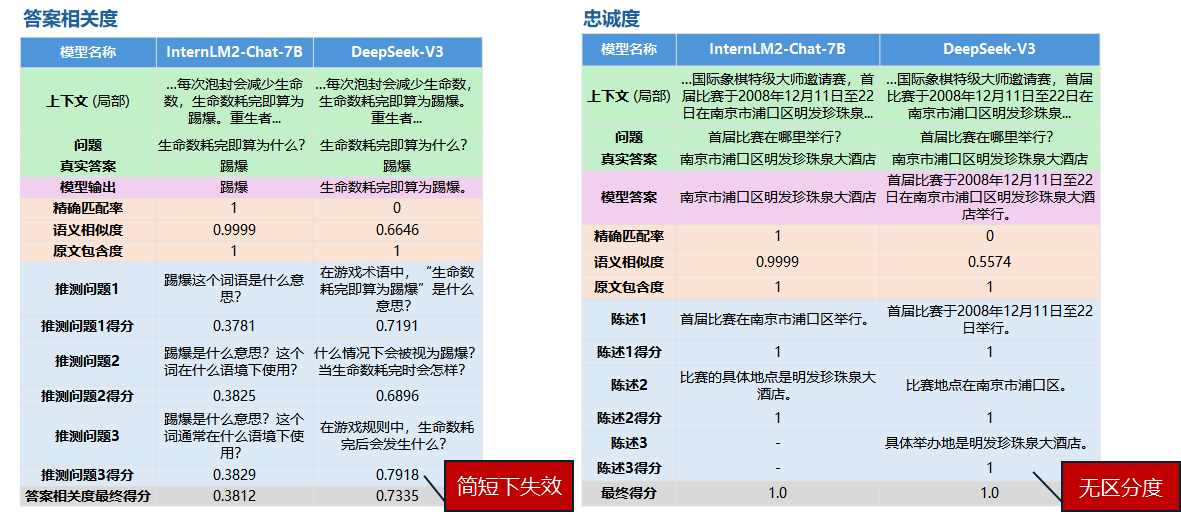

这里，针对我们的任务特点，设计了三个维度的评价指标：

* 精确匹配率（Exact Match）
* 语义相似度（Cosine Score）
* 原文包含度（Origin Score）

我们现在来详细介绍一下这三个指标的设计细节：

#### **1. 精确匹配率**

我们将精确匹配度定义如下：

$$
EM = \frac{1}{N} \sum_{i=1}^N \mathbb{I}(y_i = \hat{y}_i)
$$

其中：

* $N$：测试样本总数；
* $y_i$：第 $i$ 个样本的标准答案；
* $\hat{y}_i$：模型预测结果；
* $\mathbb{I}$：指示函数（完全匹配时取1，否则取0）；

该指标的特性在于：预测结果与标准答案需要**完全一致**

在不考虑计算平均值下，只实现其中的一项代码很简单，如下所示：

In [ ]:
exact_score = 1 if output == true_v else 0


**代码功能：**

该代码用于判断模型对单个样本的预测结果（`output`）与该样本的标准答案（`true_v`）是否完全一致，并据此给出一个精确匹配得分（`exact_score`）。

**代码解释：**

* `output`：模型对某个样本的预测结果。
* `true_v`：该样本的标准答案。
* `exact_score`：精确匹配得分，取值为1或0。如果预测结果与标准答案完全一致，则得分为1；否则得分为0。

#### **2. 语义相似度**

我们将语义相似度度定义如下：

$$
CS = \dfrac{1}{N} \sum_{i=1}^N \max\left(0, \min\left(1, \dfrac{emb(y_i) \cdot emb(\hat{y}_i)}{\|emb(y_i)\| \cdot \|emb(\hat{y}_i)\|}\right)\right)
$$

其中：

* $N$：测试样本总数；
* $y_i$：第 $i$ 个样本的标准答案；
* $\hat{y}_i$：模型预测结果；
* $emb()$：是基于 BGE 模型（bge-large-zh-v1.5）的向量编码，它可以把自然语言编码为一个向量，即：

  $$
  emb(text) = BGE\_Encoder(text)
  $$

值得注意的是：该评价指标将原本[-1,0)的数值进行了截断，只要是负相关的语义都给0分，得分只能是正相关的。

相应的代码实现如下，这里不含求平均，只是其中一项，同时假设文本已经被BGE模型向量化了：

In [ ]:
import numpy as np

def cosine(x, y):
    """Calculate cosine similarity between two vectors"""
    product = np.dot(x, y)
    norm = np.linalg.norm(x) * np.linalg.norm(y)
    raw_cosine = product / norm if norm != 0 else 0.0
    return max(0.0, min(raw_cosine, 1.0))


**代码功能：**

该代码实现了一个计算两个向量之间余弦相似度的函数，特别适用于评估模型预测结果与标准答案之间的语义相似度。这是上述精确匹配度定义（CS）中的核心计算部分，用于单个样本的相似度计算。

**代码解释：**

* $x$ 和 $y$：分别代表两个向量，在实际应用中，这两个向量通常是由 BGE 模型对文本进行向量化后的结果，即 $emb(y_i)$ 和 $emb(\hat{y}_i)$。
* $\text{np.dot}(x, y)$：计算两个向量的点积。
* $\text{np.linalg.norm}(x)$ 和 $\text{np.linalg.norm}(y)$：分别计算向量 $x$ 和 $y$ 的 L2 范数（即欧几里得范数）。
* $\frac{\text{product}}{\text{norm}}$：计算原始的余弦相似度值。
* $\text{raw\_cosine}$：存储原始的余弦相似度值，但如果分母为 0（即两个向量中至少有一个是零向量），则直接返回 0.0。
* $\max(0.0, \min(\text{raw\_cosine}, 1.0))$：对原始的余弦相似度值进行截断处理，确保结果在 $[0, 1]$ 范围内，且负相关的语义得 0 分。

#### **3. 原文包含度**

我们将原文包含度定义如下：

$$
OS = \dfrac{1}{N} \sum_{i=1}^N \mathbb{I}\left(\forall w \in \hat{y},\ w \in Context \right)
$$

其中：

* $N$：测试样本总数；
* $\hat{y}_i$：模型预测结果；
* $w$：表示预测结果中的每个字；
* $Context$：文章内容；
* $\mathbb{I}$：指示函数（所有字在原文中出现时取 1，否则有多于原文的字都取 0）。

相应的代码我们实现如下，这里不含求平均，只涉及其中一项：

In [ ]:
def check_words_from_content(infer, content):
    """Check if all words in inference output exist in original context"""
    return 1 if all(w in content for w in infer.split()) else 0

**代码功能：**

该代码实现了一个函数`check_words_from_content`，用于检查模型预测结果中的所有字是否都出现在原文内容中。这是上述原文包含度（OS）定义中的核心计算部分，用于单个样本的包含度判断。

**代码解释：**

* `infer`：模型对某个样本的预测结果，即 $\hat{y}$。
* `content`：该样本的原文内容，即 $Context$。
* `infer.split()`：将预测结果分割成单个字的列表。
* `all(w in content for w in infer.split())`：使用 Python 的 `all` 函数和生成器表达式检查 `infer` 中的每个字或词汇是否都存在于 content 中。如果所有字或词汇都存在，则返回 `True`；否则返回 `False`。
* `return 1 if ... else 0`：根据检查结果返回 1 或 0，作为指示函数 $\mathbb{I}$ 的实现。如果所有字或词汇都存在于原文中，则返回 1；否则返回 0。

#### **4. 指标对比分析**

我们将上面三个评价指标分别做对比分析：

| **指标维度** | **取值范围（单项）** | **理想值（单项）** | **数值特征（单项** | **优势**   | **局限性** | **任务评价维度说明**                                               |
| -------------------- | ---------------------------------------- | -------------------------------------- | ---------------------------------------- | ------------------ | ------------------ | -------------------------------------------------------------------------- |
| 精确匹配率         | {0, 1}                                 | 1.0                                  | 二元判断                               | 结果明确，无歧义 | 对表述差异零容忍 | 有多少推理能100%忠于答案                                                 |
| 语义相似度         | [0, 1]                                 | 1.0                                  | 连续数值                               | 捕捉语义相似性   | 依赖编码模型质量 | 由于选取片段范围，或者表述有改变，所以用相似度来评价同一内容的不同表述； |
| 原文包含度         | {0, 1}                                 | 1.0                                  | 二元判断                               | 确保答案忠实原文 | 忽略合理同义替换 | 任务要求，回答必须是用原文，此指标可反映答案是否都源自原文；             |

### 综合评测脚本

让我们将以上评价指标都汇集在一起，实现下面的完整评价：

[代码GitHub链接🔗](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter9/run_cmrc.py#L84)

In [ ]:
def caculate_score(eval_set, infer_set):
    """Calculate three evaluation metrics: exact match, cosine similarity, and word containment"""
    assert len(eval_set) == len(infer_set)

    # Initialize embedding model
    m = lazyllm.TrainableModule('bge-large-zh-v1.5')
    m.start()

    accu_exact_score = 0
    accu_cosin_score = 0
    accu_origi_score = 0
    res = []
    for index, eval_item in enumerate(eval_set):
        output = infer_set[index].strip()
        true_v = eval_item['answers']
        # Exact match scoring:
        exact_score = 1 if output == true_v else 0
        accu_exact_score += exact_score
        # Cosine similarity scoring:
        outputs = json.loads(m([output, true_v]))
        cosine_score = cosine(outputs[0], outputs[1])
        accu_cosin_score += cosine_score
        # Word containment scoring:
        origin_score = check_words_from_content(output, eval_item['context'])
        accu_origi_score += origin_score
        res.append({'context':eval_item['context'],
                    'true': true_v,
                    'infer':output,
                    'exact_score': exact_score,
                    'cosine_score': cosine_score,
                    'origin_score': origin_score})
    save_res(res, 'eval/infer_true_cp.json')
    total_score = len(eval_set)
    return (f'Exact Score : {accu_exact_score}/{total_score}, {round(accu_exact_score/total_score,4)*100}%\n'
            f'Cosine Score: {accu_cosin_score}/{total_score}, {round(accu_cosin_score/total_score,4)*100}%\n'
            f'Origin Score: {accu_origi_score}/{total_score}, {round(accu_origi_score/total_score,4)*100}%\n')

上面代码中：

* 首先传入测试集和推理的结果，并确保两个集合是一样大的；
* 然后这里为了实现文本的向量化，我们采用LazyLLM的`TrainableModule`来加载一个`bge-large-zh-v1.5`模型，并采用`.start`给它部署起来；
* 接着我们遍历所有数据，计算三个指标下的每次得分，并累计起来；
* 最后我们保存所有结果，并计算最终的评价结果并以字符串返回。

### 评测结果对比

这里我们对比了微调前模型Internlm2-Chat-7B，及其微调后的模型，同时我们还对比了线上模型DeepSeek-V3。

下表结果中，括号内是得分，总分是1002分，百分比是得分占总分的百分比。

| **模型**          | **精确匹配率**  | **语义相似度**    | **原文包含度**  |
| ------------------------- | ----------------------- | ------------------------- | ----------------------- |
| Internlm2-Chat-7B      | 2.10%(21)             | 74.51%(746.6)           | 5.19%(52)             |
| DeepSeek-V3             | 5.29%(53)             | 74.85%(750.0)           | 15.17%(152)           |
| Internlm2-Chat-7B训练后 | **39.72%**(398) | **86.19%**(863.6) | **94.91%**(951) |

从上面的评测结果我们可以看出，微调后的模型要比微调前，甚至是在线大模型的各项指标都要明显好。

1. **精确匹配率飞跃**
   1. 微调后提升 ​**37.62个百分点**​（2.10% → 39.72%），**超过在线模型近8倍**
   2. 说明模型学会遵循特定答案格式
2. **语义相关性优化**
   1. 相似度提升11.68个百分点（74.51% → 86.19%）
   2. 与在线模型（600多B的大模型）对比：**+11.34个百分点优势**
3. **原文依赖度质变**
   1. 包含度从5.19%跃升至94.91%，**提升幅度达18.3倍**
   2. 表明模型已掌握：
      * ✅ 关键信息定位能力
      * ✅ 原文提取策略
      * ✅ 知识边界控制（避免幻觉）

基于实验数据我们可以得出结论：

RAG系统中，在召回模块准确和召回无误的前提下，生成模块中模型对任务的适应程度大大影响着最终的效果，而微调是一个有效的手段可以提升模型适应下游任务的能力，甚至通过微调后提升的该能力是可以很好超过通用大模型的。

### 通用评测对比

这里我们基于[提升RAG召回](https://kh8gmexazp.feishu.cn/wiki/L8wDwa6FciHrUdk0r3WcgxHOnte)中介绍的两个通用生成模块的评价指标来评测一下模型，并与我们设计的评价指标做对比。

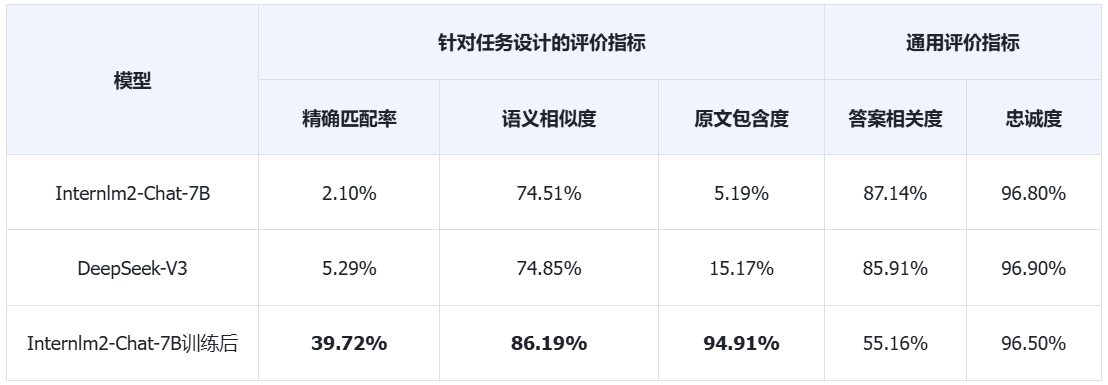

从上面表格的数据我们可以看到通用评价指标显示，在微调之后模型的答案相关度明显下降了，在这评价指标下说明微调是失败的，但真的如此吗？让我们抽取评测过程的数据来看看吧：

InternLM2-Chat-7B微调后,**答案相关度**

In [ ]:
{
    "context": "基于《跑跑卡丁车》与《泡泡堂》上所开发的游戏，由韩国Nexon开发与发行。中国大陆由盛大游戏运营，这是Nexon时隔6年再次授予盛大网络其游戏运营权。台湾由游戏橘子运营。玩家以水枪、小枪、锤子或是水炸弹泡封敌人(玩家或NPC)，即为一泡封，将水泡击破为一踢爆。若水泡未在时间内踢爆，则会从水泡中释放或被队友救援(即为一救援)。每次泡封会减少生命数，生命数耗完即算为踢爆。重生者在一定时间内为无敌状态，以踢爆数计分较多者获胜，规则因模式而有差异。以2V2、4V4随机配对的方式，玩家可依胜场数爬牌位(依序为原石、铜牌、银牌、金牌、白金、钻石、大师) ，可选择经典、热血、狙击等模式进行游戏。若游戏中离，则4分钟内不得进行配对(每次中离+4分钟)。开放时间为暑假或寒假期间内不定期开放，8人经典模式随机配对，采计分方式，活动时间内分数越多，终了时可依该名次获得奖励。",
    "exact_score": 1,
    "cosine_score": 0.9999,
    "origin_score": 1,
    "question": "生命数耗完即算为什么？",
    "true_answer": "踢爆",
    "answer": "踢爆",
    "infer_questions": [
        {
            "question": "\n踢爆这个词语是什么意思？",
            "score": 0.3781
        },
        {
            "question": "\n踢爆是什么意思？这个词在什么语境下使用？",
            "score": 0.3825
        },
        {
            "question": "\n踢爆是什么意思？这个词通常在什么语境下使用？",
            "score": 0.3829
        }
    ],
    "final_score": 0.3812
},


DeepSeek-V3,**答案相关度**

In [ ]:
{
    "context": "基于《跑跑卡丁车》与《泡泡堂》上所开发的游戏，由韩国Nexon开发与发行。中国大陆由盛大游戏运营，这是Nexon时隔6年再次授予盛大网络其游戏运营权。台湾由游戏橘子运营。玩家以水枪、小枪、锤子或是水炸弹泡封敌人(玩家或NPC)，即为一泡封，将水泡击破为一踢爆。若水泡未在时间内踢爆，则会从水泡中释放或被队友救援(即为一救援)。每次泡封会减少生命数，生命数耗完即算为踢爆。重生者在一定时间内为无敌状态，以踢爆数计分较多者获胜，规则因模式而有差异。以2V2、4V4随机配对的方式，玩家可依胜场数爬牌位(依序为原石、铜牌、银牌、金牌、白金、钻石、大师) ，可选择经典、热血、狙击等模式进行游戏。若游戏中离，则4分钟内不得进行配对(每次中离+4分钟)。开放时间为暑假或寒假期间内不定期开放，8人经典模式随机配对，采计分方式，活动时间内分数越多，终了时可依该名次获得奖励。",
    "exact_score": 0,
    "cosine_score": 0.6646,
    "origin_score": 1,
    "question": "生命数耗完即算为什么？",
    "true_answer": "踢爆",
    "answer": "生命数耗完即算为踢爆。",
    "infer_questions": [
        {
            "question": "\n在游戏术语中，\"生命数耗完即算为踢爆\"是什么意思？",
            "score": 0.7191
        },
        {
            "question": "\n什么情况下会被视为踢爆？当生命数耗完时会怎样？",
            "score": 0.6896
        },
        {
            "question": "\n在游戏规则中，生命数耗完后会发生什么？",
            "score": 0.7918
        }
    ],
    "final_score": 0.7335
},


上面对比中，`true_answer`是标注的答案，`answer`是模型推理的答案， `question`是问题，**答案相关度**需要根据模型推理的答案`answer`来生成可能的问题（`infer_questions`中的`question`），这里是三个，然后让可能的问题与真实问题在向量化后求余弦相似度。在简短的`answer`之下，模型很难推测出和真实问题`question`相关的问题。

* 微调后的InternLM2-Chat-7B的`answer`是："踢爆"
* DeepSeek-V3的`answer`是："生命数耗完即算为踢爆。"

可以看到DeepSeek-V3因为提供的信息更多，所以评价模型推测出来的问题更加准确，所以得分就更高。但实际上这不符合我们的预期，我们希望它简短准确，正如标准答案"踢爆"一样！与之对应的我们这里采用的语义相似度`cosine_score`和`exact_score`精准匹配度就很好的反映预期。

忠诚度在这里几乎没有什么区分度：

InternLM2-Chat-7B微调后,忠诚度：

In [ ]:
{
    "context": "中国（南京）国际象棋超级大赛（Pearl Spring Super Tournament）原名中国（南京）国际象棋特级大师邀请赛，首届比赛于2008年12月11日至22日在南京市浦口区明发珍珠泉大酒店举行。本次大赛由南京市人民政府、国家体育总局棋牌运动管理中心主办，浦口区人民政府、南京市体育局承办，康缘药业股份有限公司、扬子晚报、蒙代尔国际企业家大学协办。被国际棋联定为21级赛事，也是亚洲迄今为止举办的最高水平的国际象棋大赛。双循环赛制比赛十轮，12月11日至15日进行前5轮，16日休息，17至21日进行后5轮。每方90分钟，每步棋加30秒。总奖金25万欧元，其中冠军8万欧元，第2至6名依次为5万5千欧元、4万欧元、3万欧元、2万5千欧元、2万欧元。结果托帕洛夫夺得冠军，阿罗尼扬获得亚军，卜祥志获得第三名。2009年2月1日被接纳为大满贯赛事并更名为中国（南京）国际象棋超级大赛。第二届比赛于2009年9月27日-10月9日举行。“康缘药业杯”2010中国(南京)国际象棋超级大赛于2010年10月19-30日举行",
    "exact_score": 1,
    "cosine_score": 0.9999,
    "origin_score": 1,
    "question": "首届比赛在哪里举行？",
    "true_answer": "南京市浦口区明发珍珠泉大酒店",
    "answer": "南京市浦口区明发珍珠泉大酒店",
    "statements": "\n首届比赛在南京市浦口区举行。|||比赛的具体地点是明发珍珠泉大酒店。",
    "scores": [
        {
            "statement": "首届比赛在南京市浦口区举行。",
            "score": 1
        },
        {
            "statement": "比赛的具体地点是明发珍珠泉大酒店。",
            "score": 1
        }
    ],
    "final_score": 1.0
},


DeepSeek-V3,忠诚度：

In [ ]:
{
    "context": "中国（南京）国际象棋超级大赛（Pearl Spring Super Tournament）原名中国（南京）国际象棋特级大师邀请赛，首届比赛于2008年12月11日至22日在南京市浦口区明发珍珠泉大酒店举行。本次大赛由南京市人民政府、国家体育总局棋牌运动管理中心主办，浦口区人民政府、南京市体育局承办，康缘药业股份有限公司、扬子晚报、蒙代尔国际企业家大学协办。被国际棋联定为21级赛事，也是亚洲迄今为止举办的最高水平的国际象棋大赛。双循环赛制比赛十轮，12月11日至15日进行前5轮，16日休息，17至21日进行后5轮。每方90分钟，每步棋加30秒。总奖金25万欧元，其中冠军8万欧元，第2至6名依次为5万5千欧元、4万欧元、3万欧元、2万5千欧元、2万欧元。结果托帕洛夫夺得冠军，阿罗尼扬获得亚军，卜祥志获得第三名。2009年2月1日被接纳为大满贯赛事并更名为中国（南京）国际象棋超级大赛。第二届比赛于2009年9月27日-10月9日举行。“康缘药业杯”2010中国(南京)国际象棋超级大赛于2010年10月19-30日举行",
    "exact_score": 0,
    "cosine_score": 0.5574,
    "origin_score": 1,
    "question": "首届比赛在哪里举行？",
    "true_answer": "南京市浦口区明发珍珠泉大酒店",
    "answer": "首届比赛于2008年12月11日至22日在南京市浦口区明发珍珠泉大酒店举行。",
    "statements": "\n首届比赛于2008年12月11日至22日举行。|||比赛地点在南京市浦口区。|||具体举办地是明发珍珠泉大酒店。",
    "scores": [
        {
            "statement": "首届比赛于2008年12月11日至22日举行。",
            "score": 1
        },
        {
            "statement": "比赛地点在南京市浦口区。",
            "score": 1
        },
        {
            "statement": "具体举办地是明发珍珠泉大酒店。",
            "score": 1
        }
    ],
    "final_score": 1.0
},


上面的对比中，我们可以看到DeepSeek-V3虽然提供了更多的信息，但它和微调后的模型一样，基本都按照要求使用原文中的内容来回答，所以虽然它的`statement`更多（3条），但最终得分和微调后模型一样。这也就解释了为什么最终的忠诚度得分没有区分度。值得注意的是这里用`cosine_score`语义相似度和`exact_score`精确匹配度，很好区分了两者的差异。

从上面的两个指标的对比结果我们可以看到，如果对RAG系统中的生成模块有特定的任务要求，常用的评价指标并不能很好衡量，此时就需要针对任务的最终效果需求来进行评价指标的设计！

## 在RAG中使用微调好的大模型

LazyLLM支持微调、部署、推理一条龙，但如果已微调好一个大模型，想直接使用它应该怎么办呢？很简单：其中的base\_model不变，用target\_path指定微调好的模型路径即可，如下所示：

In [ ]:
base_model = 'internlm2-chat-7b'
sft_model = '/path/to/sft/internlm2-chat-7b'

llm = lazyllm.TrainableModule(base_model, sft_model)

以基础的RAG为例就是：

In [ ]:
import os
import lazyllm

prompt = ('You will act as an AI question-answering assistant and complete a dialogue task.'
          'In this task, you need to provide your answers based on the given context and questions.')

base_model = 'internlm2-chat-7b'
sft_model = '/path/to/sft/internlm2-chat-7b'
llm = lazyllm.TrainableModule(base_model, sft_model)

documents = lazyllm.Document(dataset_path=os.path.join(os.getcwd(), "KB"), embed=embed = lazyllm.TrainableModule('bge-large-zh-v1.5'), manager=False)
documents.create_node_group(name='split_sent', transform=lambda s: s.split('\n'))
with lazyllm.pipeline() as ppl:
    ppl.retriever = lazyllm.Retriever(
        doc=documents, group_name="split_sent", similarity="cosine", topk=1, output_format='content', join='')
    ppl.formatter = (lambda nodes, query: dict(context_str=nodes, query=query)) | lazyllm.bind(query=ppl.input)
    ppl.llm = llm.prompt(lazyllm.ChatPrompter(instruction=prompt, extra_keys=['context_str']))

ppl.start()

## 实验过程

三个模型的实验过程如下视频所示：

1. Internlm2-Chat-7B的部署、推理和评测：

[相关视频：video/1origin.mp4](video/1origin.mp4)

2. Internlm2-Chat-7B的微调、部署、推理和评测：

[相关视频：video/2sft.mp4](video/2sft.mp4)

3. DeepSeek-V3的推理和评测：

[相关视频：video/3deepseek.mp4](video/3deepseek.mp4)

# 基于LazyLLM对Embedding模型进行微调

在RAG（Retrieval-Augmented Generation）系统中，Embedding模型承担着关键作用：

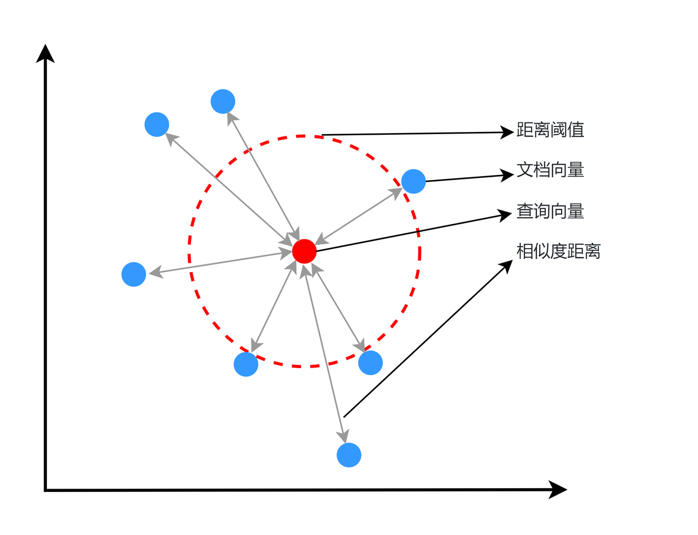

* ​**语义编码**​：将文本数据转换为高维向量表示，保留语义信息
* **​相似度计算：​**通过向量余弦相似度实现高效的相关性检索
* ​**知识库索引**​：预先编码文档库，建立快速检索的向量索引
* ​**查询理解**​：将用户query转换为向量，匹配最相关的知识片段

在本教程中，我们将使用BAAI的bge-large-zh-v1.5作为基础模型，通过金融领域数据微调（SFT）来提升垂直领域效果。

## 数据准备

在 embedding 学习中，我们的目标是让：

* 语义相似的样本（正样本对，positive pair）在向量空间中更靠近。
* 语义无关或相反的样本（负样本对，negative pair）距离更远。

而负样本的作用是提供一个对比参照，让模型知道“哪些是不该靠近的”。例如当我们的query为“ChatGPT是什么？”的时候，我们的正样本的doc为“ChatGPT 是由 OpenAI 开发的语言模型，基于 Transformer 架构……”，我们的负样本的doc可以设置为“Midjourney 是一个 AI 图像生成模型……”。

这里我们使用金融问答数据集：[virattt/financial-qa-10K](https://huggingface.co/datasets/virattt/financial-qa-10K)来进行演示：

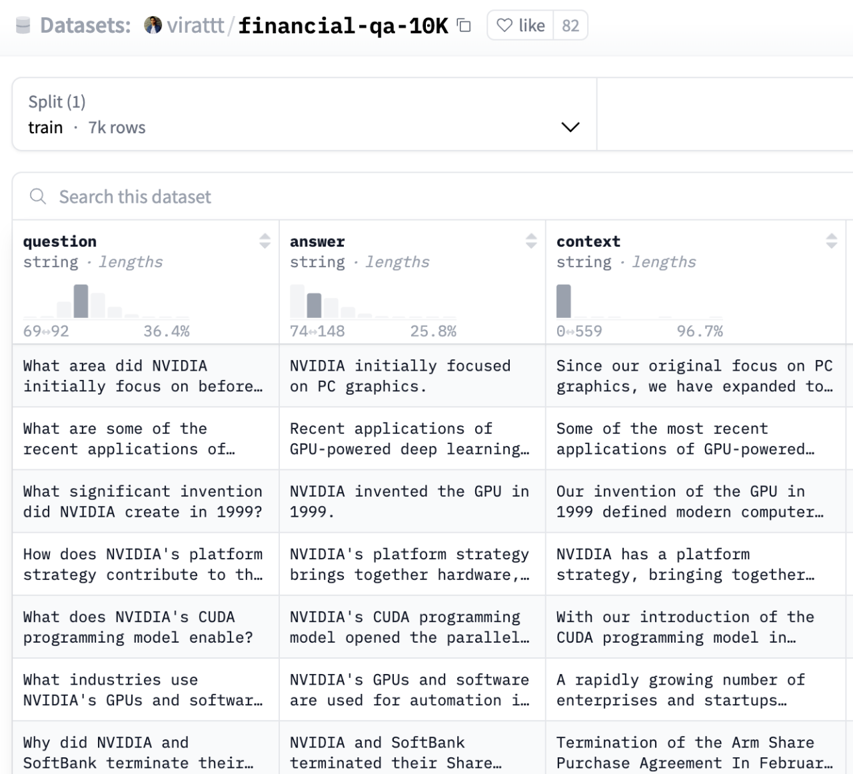

数据处理流程：

1. 加载原始数据集
2. 生成负样本（每个样本10个负例）
3. 创建训练集/评测集分割（9:1比例）
4. 构建知识库文件

主要代码实现如下所示：

In [ ]:
def build_dataset_corpus(instruction: str, neg_num: int = 10, test_size: float = 0.1, seed: int = 1314) -> tuple:
    """Process dataset and create training/evaluation files.

    Args:
        instruction (str): Instruction template for prompts
        neg_num (int): Number of negative samples per instance
        test_size (float): Proportion of data for test split
        seed (int): Random seed for reproducibility

    Returns:
        tuple: Paths to training data, evaluation data, and knowledge base directory
    """
    # Load and preprocess dataset
    ds = load_dataset("virattt/financial-qa-10K", split="train")
    ds = ds.select_columns(column_names=["question", "context"])
    ds = ds.rename_columns({"question": "query", "context": "pos"})

    # Generate negative samples
    np.random.seed(seed)
    new_col = []
    for i in range(len(ds)):
        ids = np.random.randint(0, len(ds), size=neg_num)
        while i in ids:  # Ensure no self-match in negatives
            ids = np.random.randint(0, len(ds), size=neg_num)
        neg = [ds[int(i)]["pos"] for i in ids]
        new_col.append(neg)

    # Create dataset splits
    ds = ds.add_column("neg", new_col)

    def str_to_lst(data):
        data["pos"] = [data["pos"]]
        return data
    ds = ds.map(str_to_lst)  # Convert pos to list format
    ds = ds.add_column("prompt", [instruction] * len(ds))
    split = ds.train_test_split(test_size=test_size, shuffle=True, seed=seed)

    # Save training data
    train_data_path = build_data_path('dataset', 'train.json')
    split["train"].to_json(train_data_path)

    # Process and save evaluation data
    test = split["test"].select_columns(["query", "pos"]).rename_column("pos", "corpus")
    eval_data_path = build_data_path('dataset', 'eval.json')
    test.to_json(eval_data_path)

    # Create knowledge base
    kb_data_path = build_data_path('KB', 'knowledge_base.txt')
    corpus = "\n".join([''.join(item) for item in test['corpus']])
    with open(kb_data_path, 'w', encoding='utf-8') as f:
        f.write(corpus)

    return train_data_path, eval_data_path, os.path.dirname(kb_data_path)

经过处理后，训练集的一条数据如下（json文件）：

In [ ]:
{"query":"What was the total stockholder's equity (deficit) for Peloton Interactive, Inc. as of June 30, 2021?","pos":["As of June 30, 2021, Peloton Interactive, Inc.'s consolidated statements reflected a total stockholder's equity (deficit) of $1,754.1 million."],"neg":["In June 2023, the company entered into an ASR agreement to repurchase $500 million of its common stock with a completion date no later than August 2023, and in 2024, the company expects to repurchase $2.0 billion of its common stock.",...,"\u2022Overhead costs as a percentage of net sales increased 40 basis points due to wage inflation and other cost increases, partially offset by the positive scale impacts of the net sales increase and productivity savings."],"prompt":"Represent this sentence for searching relevant passages: "}

需要包含如下字段：

* `query`: （str）用户提问
* `pos`：（List[str]）正确答案段落
* `neg`：（List[str]）随机采样的负样本
* `prompt`: （str）指令模板

评测集的一条数据如下（json文件）：

In [ ]:
{"query":"How have certain vendors been impacted in the supply chain financing market?","corpus":["Certain vendors have been impacted by volatility in the supply chain financing market."]}


需要包含如下字段：

* `query`: 用户提问
* `corpus`: 对应提问的正确文本片段

知识库局部如下（txt文件）：

In [ ]:
Certain vendors have been impacted by volatility in the supply chain financing market.
Recruitment As the demand for global technical talent continues to be competitive, we have grown our technical workforce and have been successful in attracting top talent to NVIDIA. We have attracted strong talent globally with our differentiated hiring strategies for university, professional, executive and diverse recruits. The COVID-19 pandemic created expanded hiring opportunities in new geographies and provided increased  flexibility for employees to work from locations of their choice. Our workforce is about 80% technical and about 50% hold advanced degrees.
In 2023, Moody’s Investors Service upgraded AbbVie’s senior unsecured long-term credit rating to A3 with a stable outlook from Baa1 with a positive outlook.


[相关视频：video/sft_embed01.mp4](video/sft_embed01.mp4)

## 微调过程

通过LazyLLM框架进行分布式微调：

In [ ]:
embed = lazyllm.TrainableModule(embed_path)\
    .mode('finetune').trainset(train_data_path)\
    .finetune_method((
        lazyllm.finetune.flagembedding,
        {
            'launcher': lazyllm.launchers.remote(nnode=1, nproc=1, ngpus=4),
            'per_device_train_batch_size': 16,
            'num_train_epochs': 2,
        }
    ))
    
docs = Document(kb_path, embed=embed, manager=False)
docs.create_node_group(name='split_sent', transform=lambda s: s.split('\n'))
retriever = lazyllm.Retriever(doc=docs, group_name="split_sent", similarity="cosine", topk=1)
retriever.update()

这里代码和前面使用LazyLLM的`TrainableModule`来对LLM进行微调的配置是一致的：

* `embed_path`: 用于指定微调的模型；
* `train_data_path`：用于训练的数据集路径；
* `lazyllm.finetune.flagembedding`: 指定微调的框架；

关键参数：

* `ngpus=4`: 使用4张GPU进行并行训练
* `per_device_batch_size=16`: 每GPU批处理大小
* `num_train_epochs=2`: 训练2个epoch

值得注意的是，这里的代码我们不仅给了embed的微调配置参数，同时后面还将其放入到了Document中，Document注册了一个按照换行符来分割知识库文档的策略，最后还配置了Retriever作用在文档及其对应的切分方式上，并以余弦相似度作为度量工具，同时让只返回最相关的一个文本段（topk=1）。因为LazyLLM是支持一键微调、部署和推理的，所以当执行`update()`后，LazyLLM会先对embed模型进行微调，然后将微调后的模型部署起来，为Document和Retriever提供向量化。

## 效果评测

这里我们使用前面教程介绍过的上下文召回率和上下文相关度来评测我们微调后的模型，作为对照，这里我们采用

bge-large-zh-v1.5来作为基模型，对照其微调前后的两个指标下的变化。

评价指标的调用如下所示：

In [ ]:
from lazyllm.tools.eval import NonLLMContextRecall, ContextRelevance

def evaluate_results(data: list) -> tuple:
    """Evaluate retrieval results using multiple metrics.

    Args:
        data (list): List of retrieval results to evaluate

    Returns:
        tuple: Evaluation scores (context recall, context relevance)
    """
    recall_eval = NonLLMContextRecall(binary=False)
    relevance_eval = ContextRelevance()
    return recall_eval(data), relevance_eval(data)

微调、部署和推理的逻辑主要如下：

In [ ]:
# Prepare dataset
train_data_path, eval_data_path, kb_path = build_dataset_corpus(
    instruction=args.instruction,
    neg_num=args.neg_num,
    test_size=args.test_size,
    seed=args.seed
)
# Deploy retrieval service
retriever = deploy_serve(
    kb_path=kb_path,
    embed_path=args.embed_path,
    train_data_path=train_data_path,
    train_flag=args.train_flag,
    per_device_batch_size=args.per_device_batch_size,
    num_epochs=args.num_epochs,
    ngpus=args.ngpus
)
# Run SFT or Evaluation
results = []
query_corpus = load_json(eval_data_path)
for item in tqdm(query_corpus, desc="Processing queries"):
    query = item['query']
    inputs = f"{args.instruction}{query}" if args.use_instruction or args.train_flag else query
    retrieved = retriever(inputs)
    results.append({
        'question': query,
        'context_retrieved': [text.get_text() for text in retrieved],
        'context_reference': item['corpus']
    })

# Save and report results
save_json(results, args.output_path)
recall_score, relevance_score = evaluate_results(results)
print(f"Evaluation Complete!\nContext Recall: {recall_score}\nContext Relevance: {relevance_score}")

基于上面的逻辑，我们获得如下结果：

|             | **微调前**​**bge-large-zh-v1.5** | **微调后**​**bge-large-zh-v1.5** |
| -------------- | ----------------------------------------------- | ----------------------------------------------- |
| 上下文召回率 | 78.28                                         | 88.57                                         |
| 上下文相关度 | 75.71                                         | 86.57                                         |

可以看到，在微调后，两个指标都得到了显著的提升。说明微调是有效的！整体的评估流程为：加载评测集 → 使用检索服务（微调后部署起来的服务）→ 执行批量推理 → 计算双指标。

**【bge-large-zh-v1.5微调前】**

[相关视频：video/sft_embed02.mp4](video/sft_embed02.mp4)

**【bge-large-zh-v1.5微调后】**

[相关视频：video/sft_embed03.mp4](video/sft_embed03.mp4)

## 在RAG中使用微调好的Embedding模型

和使用微调好的LLM类似，这里我们也可以使用微调好的Embedding模型，如下所示：

In [ ]:
import os
import lazyllm

prompt = ('You will act as an AI question-answering assistant and complete a dialogue task.'
          'In this task, you need to provide your answers based on the given context and questions.')

embed = lazyllm.TrainableModule('bge-large-zh-v1.5', 'path/to/sft/bge')

documents = lazyllm.Document(dataset_path=os.path.join(os.getcwd(), "KB"), embed=embed, manager=False)
documents.create_node_group(name='split_sent', transform=lambda s: s.split('\n'))
with lazyllm.pipeline() as ppl:
    ppl.retriever = lazyllm.Retriever(
        doc=documents, group_name="split_sent", similarity="cosine", topk=1, output_format='content', join='')
    ppl.formatter = (lambda nodes, query: dict(context_str=nodes, query=query)) | lazyllm.bind(query=ppl.input)
    ppl.llm = lazyllm.OnlineChatModule(source="sensenova")\
        .prompt(lazyllm.ChatPrompter(instruction=prompt, extra_keys=['context_str']))

ppl.start()

# 扩展阅读

## 更多微调方法

从模型中被更新的参数范围的角度来看，除了上述介绍的LoRA微调之外，常见的微调有全参数微调、冻结微调等

### 1. 全参数微调

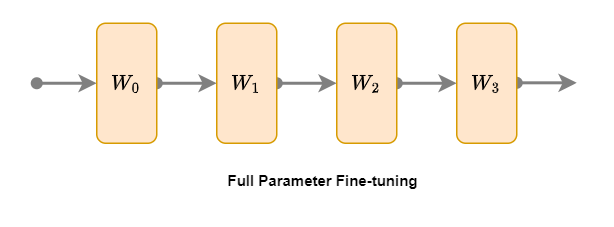

全参数微调（Full Parameter Fine-tuning）是一种最直接的微调方法，其主要思想是在预训练模型（已微调的模型上也行）的基础上，针对特定任务对整个模型的​**所有参数进行微调**​。如上图所示，模型四层橙色的参数：W1、W2、W3、W4 都要参与微调。具体步骤如下：

1. 加载预训练模型：使用预训练好的大语言模型作为基础模型。
2. 准备任务数据：根据特定任务，收集并整理相关数据。
3. 微调模型：将任务数据输入模型，通过反向传播算法更新模型的所有参数。
4. 评估与优化：在验证集上评估微调后的模型性能，根据需求进行优化。

全参数微调的优势在于能够充分挖掘模型在特定任务上的潜力，但缺点是计算资源消耗较大，且容易过拟合。

### 2. 冻结微调

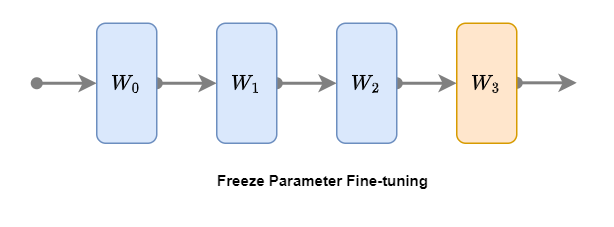

冻结微调（Freeze Parameter Fine-tuning）是一种节省计算资源的微调方法。在冻结微调过程中，预训练模型（已微调的模型上也行）的底层参数保持不变，​**仅对部分层参数进行微调**​（冻结微调可以冻结任意层，常见的是对模型顶层进行微调）。如上图所示，将模型前三层蓝色W0、W1和W2进行冻结，仅微调最后一层(顶层)橙色W3。具体步骤如下：

1. 加载预训练模型：使用预训练好的大语言模型。
2. 冻结底层参数：将模型底层参数固定，不参与训练。
3. 微调顶层参数：将任务数据输入模型，仅更新顶层参数。
4. 评估与优化：在验证集上评估模型性能，根据需求进行优化。

冻结微调的优势在于计算资源消耗较小，但相较于全参数微调，模型性能可能会有所下降。

我们将这几种微调技术总结如下：

| **微调方法**                                | **计算资源消耗** | **参数更新范围** | **优势**             | **劣势**         |
| --------------------------------------------------- | ------------------------ | ------------------------ | ---------------------------- | ------------------------ |
| **全参数微调 (Full Parameter Fine-tuning)** | 高                    | 所有参数               | 充分挖掘模型潜力，适应性强 | 资源消耗大，容易过拟合 |
| **冻结微调 (Freeze)**                      | 低                     | 仅部分层参数           | 节省计算资源，快速训练     | 性能可能不如全参数微调 |
| **LoRA微调**                                | 中                     | 低秩矩阵               | 节省资源，保持预训练优势   | 对模型结构有一定限制   |

## 微调数据格式

前文简单提及了我们将数据集字段处理成了：Instruction、input和output的格式，这属于Alpaca指令微调的数据格式。这里我们不仅详细介绍该指令微调格式，而且还介绍另外一种常用格式：OpenAI 指令微调数据格式。

### 1. Alpaca 指令微调数据格式

Alpaca 格式是一种用于指令微调的数据格式，它包含了指令、输入、输出、系统提示词和历史对话等信息。该格式适用于单轮和多轮对话场景，允许模型根据历史信息生成更准确的回答。

#### 数据基本格式

该数据的基本结构如下：

In [ ]:
[
  {
    "instruction": "人类的指令（必填）",
    "input": "人类的输入（选填）",
    "output": "模型的回答（必填）",
    "system": "系统的提示词（选填）",
    "history": [
      ["第一轮的指令（选填）", "第一轮的回答（选填）"],
      ["第二轮的指令（选填）", "第二的轮回答（选填）"]
    ]
  }
]

**1. “instruction”（必填）**

* ​**描述**​：这个字段包含了用户给出的指令或问题，是模型需要理解和响应的核心内容。
* ​**示例**​：对于单轮对话，可能是“请告诉我今天的天气情况。”；对于多轮对话，可能是“我想了解关于人工智能的信息。”

**2. “input”（选填）**

* ​**描述**​：这个字段用于提供额外的输入信息，可能是与指令相关的背景信息、上下文或具体数据。
* ​**示例**​：在单轮对话中，如果**指令**是“翻译以下句子”，则**输入**可能是“Hello, how are you?”；在多轮对话中，可能不填或提供上一轮对话的补充信息。

**3. “output”（必填）**

* ​**描述**​：这个字段包含了模型针对指令和输入生成的回答或输出。
* ​**示例**​：对于单轮对话，可能是“今天天气晴朗，温度为20摄氏度。”；对于多轮对话，可能是“人工智能是模拟人类智能行为的技术。”

**4. “system”（选填）**

* ​**描述**​：这个字段用于提供系统级别的提示词或指令，可以指导模型的行为或回答风格。
* ​**示例**​：可能是“请以正式的语气回答。”或“在回答时尽量使用简单词汇。”

**5. “history”（选填）**

* ​**描述**​：这个字段是一个数组，用于存储多轮对话的历史信息，每个元素是一个包含两个字符串的数组，分别代表一轮对话中的用户指令和模型回答。
* ​**示例**​：在多轮对话中，可能包含如下历史信息：

In [ ]:
[
    ["什么是人工智能？", "人工智能是模拟人类智能行为的技术。"],
    ["人工智能有哪些应用？", "人工智能应用于自动驾驶、语音识别、图像处理等领域。"]
]

#### 单轮对话示例

In [ ]:
[
  {
    "instruction": "请告诉我今天的天气情况。",
    "input": "",
    "output": "今天天气晴朗，温度为20摄氏度。",
    "system": "",
    "history": []
  }
]

#### 多轮对话示例

In [ ]:
[
  {
    "instruction": "我想了解关于人工智能的信息。",
    "input": "",
    "output": "人工智能是模拟人类智能行为的技术。",
    "system": "",
    "history": [
      ["什么是人工智能？", "人工智能是模拟人类智能行为的技术。"],
      ["人工智能有哪些应用？", "人工智能应用于自动驾驶、语音识别、图像处理等领域。"]
    ]
  }
]

### **2. OpenAI 指令微调数据格式**

OpenAI 格式是一种用于指令微调的数据格式，它通过角色（role）和内容（content）来组织对话。角色可以是系统（system）、用户（user）或助手（assistant），内容则是对应角色的发言。该格式同样适用于单轮和多轮对话场景。

#### 数据基本格式

该数据的基本结构如下：

In [ ]:
{
    "messages": [
      {
        "role": "system",
        "content": "系统提示词（选填）"
      },
      {
        "role": "user",
        "content": "人类指令"
      },
      {
        "role": "assistant",
        "content": "模型回答"
      }
    ]
}

**1. “messages”**

* ​**描述**​：这个字段是一个数组，包含了整个对话的所有轮次，每个轮次由 “role” 和 “content” 组成。

**2. “role”**

* ​**描述**​：这个字段表示消息的角色，可以是 “system”、“user” 或 “assistant”。
  * ​“system”​：系统提示词，用于提供背景信息或指导模型的行为。
  * ​“user”​：用户角色，表示用户的指令或问题。
  * ​“assistant”​：助手角色，表示模型的回答或输出。

**3. “content”**

* ​**描述**​：这个字段包含了对应角色的具体内容。
* ​**示例**​：对于 “system” 角色，可能是“请以友好的语气回答。”；对于 “user” 角色，可能是“我想了解关于人工智能的信息。”；对于 “assistant” 角色，可能是“人工智能是模拟人类智能行为的技术。”

#### 单轮对话示例

In [ ]:
{
  "messages": [
    {
      "role": "system",
      "content": ""
    },
    {
      "role": "user",
      "content": "请告诉我今天的天气情况。"
    },
    {
      "role": "assistant",
      "content": "今天天气晴朗，温度为20摄氏度。"
    }
  ]
}

#### 多轮对话示例

In [ ]:
{
  "messages": [
    {
      "role": "system",
      "content": ""
    },
    {
      "role": "user",
      "content": "我想了解关于人工智能的信息。"
    },
    {
      "role": "assistant",
      "content": "人工智能是模拟人类智能行为的技术。"
    },
    {
      "role": "user",
      "content": "人工智能有哪些应用？"
    },
    {
      "role": "assistant",
      "content": "人工智能应用于自动驾驶、语音识别、图像处理等领域。"
    }
  ]
}